
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [428]:
!pip install XGboost

In [429]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve
from xgboost import XGBClassifier
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

In [430]:
def wrangle(filepath):
    df = pd.read_csv(filepath, index_col='kepid')
    
    # https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html
    # Link above provided further explination on what columns represented
    df = df.rename(columns={'kepid': 'KepID',
                            'kepoi_name' : 'Kepler_Name',
                            'koi_disposition' : 'Exoplanet_Archive_Disposition',
                            'koi_pdisposition' : 'Disposition_Using_Kepler_Data',
                            'koi_score' : 'Disposition_Score',
                            'koi_fpflag_nt' : 'Not_Transit-Like_False_Positive_Flag',
                            'koi_fpflag_ss' : 'Stellar_Eclipse_False_Positive_Flag',
                            'koi_fpflag_co' : 'Centroid_Offset_False_Positive_Flag',
                            'koi_fpflag_ec' : 'Ephemeris_Match_Indicates_Contamination_False_Positive_Flag',
                            'koi_period' : 'Orbital_Period_Days',
                            'koi_period_err1' : 'Orbital_Period_Upper',
                            'koi_period_err2' : 'Orbital_Period_Lower',
                            'koi_time0bk' : 'Transit_Epoch',
                            'koi_time0bk_err1' : 'Transit_Epoch_Upper',
                            'koi_time0bk_err2' : 'Transit_Epoch_Lower',
                            'koi_impact' : 'Impact_Parameter',
                            'koi_impact_err1' : 'Impact_Parameter_Upper',
                            'koi_impact_err2' : 'Impact_Parameter_Lower',
                            'koi_duration': 'Transit_Duration',
                            'koi_duration_err1':'Transit_Duration_Upper',
                            'koi_duration_err2':'Transit_Duration_Lower',
                            'koi_depth' : 'Transit_Depth',
                            'koi_depth_err1' : 'Transit_Depth_Upper',
                            'koi_depth_err2' : 'Transit_Depth_Lower',
                            'koi_prad' : 'Planetar_Radius',
                            'koi_prad_err1' : 'Planetary_Radius_Upper',
                            'koi_prad_err2' : 'Planetary_Radius_Lower',
                            'koi_teq' : 'Equilibrium_Temperature',
                            'koi_teq_err1' : 'Equilibrium_Temperature_Upper',
                            'koi_teq_err2' : 'Equilibrium_Temperature_Lower',
                            'koi_insol' : 'Insoluation_Flux',
                            'koi_insol_err1' : 'Insolation_Flux_Upper',
                            'koi_insol_err2' : 'Insolation_Flux_Lower',
                            'koi_model_snr' : 'Transit_Signal',
                            'koi_tce_plnt_num' : 'TCE_Planet_Number',
                            'koi_tce_delivname' : 'TCE_Delive_Name',
                            'koi_steff' : 'Stellar_Effective_Temperature',
                            'koi_steff_err1' : 'Stellar_Effective_Temperature_Upper',
                            'koi_steff_err2' : 'Stellar_Effective_Temperature_Lower',
                            'koi_slogg' : 'Stellar_Surface_Gravity',
                            'koi_slogg_err1' : 'Stellar_Surface_Gravity_Upper',
                            'koi_slogg_err2' : 'Stellar_Surface_Gravity_Lower',
                            'koi_srad' : 'Stellar_Radius',
                            'koi_srad_err1' : 'Stellar_Radius_Upper',
                            'koi_srad_err2' : 'Stellar_Radius_Lower',
                            'ra' : 'RA',
                            'dec' : 'Dec',
                            'koi_kepmag' : 'Keplar_Band',
                
                           })
    # Drop high null Columns
    df = df.drop(columns = ['Equilibrium_Temperature_Upper', 'Equilibrium_Temperature_Lower'])
    
    # Drop for base test
    df = df.drop(columns = ['TCE_Delive_Name', 'Kepler_Name', 'kepler_name','rowid'])
    
    # Drop possible leakage
    df = df.drop(columns = ['Disposition_Score'])
    
    # Drop these for possible leakage. Need to look into further.
    df = df.drop(columns = ['Not_Transit-Like_False_Positive_Flag',
                            'Ephemeris_Match_Indicates_Contamination_False_Positive_Flag',
                            'Stellar_Eclipse_False_Positive_Flag', 'Centroid_Offset_False_Positive_Flag'])
    
    # Drop Nans for now
    df = df.dropna()
    
    # Combined the Upper and Lower Errors into one column. Drop Upper, Lower columns
    for col in df.columns:
        if col in df.filter(regex='_Upper', axis=1).columns.to_list():
            df[col.replace('_Upper', '_Error')] = df[col] - df[col.replace('_Upper', '_Lower')]
            df = df.drop(columns= [col,col.replace('_Upper', '_Lower')])

    
#     # Experiment with possible negative accuracy value
    df = df.drop(columns = ['Transit_Epoch_Error'])
        
    return df

In [431]:
df = wrangle('D:\\Download\\NASA\\cumulative.csv')

df.head()

,Exoplanet_Archive_Disposition,Disposition_Using_Kepler_Data,Orbital_Period_Days,Transit_Epoch,Impact_Parameter,Transit_Duration,Transit_Depth,Planetar_Radius,Equilibrium_Temperature,Insoluation_Flux,...,Keplar_Band,Orbital_Period_Error,Impact_Parameter_Error,Transit_Duration_Error,Transit_Depth_Error,Planetary_Radius_Error,Insolation_Flux_Error,Stellar_Effective_Temperature_Error,Stellar_Surface_Gravity_Error,Stellar_Radius_Error
kepid,,,,,,,,,,,,,,,,,,,,,
10797460,CONFIRMED,CANDIDATE,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,...,15.347,5.550000e-05,0.464,0.16380,39.0,0.41,46.10,162.0,0.160,0.166
10797460,CONFIRMED,CANDIDATE,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,...,15.347,4.958000e-04,0.502,0.23200,71.0,0.51,4.49,162.0,0.160,0.166
10811496,FALSE POSITIVE,FALSE POSITIVE,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,...,15.436,2.988000e-05,5.203,0.06820,342.0,5.23,41.53,334.0,0.220,0.311
10848459,FALSE POSITIVE,FALSE POSITIVE,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,...,15.597,5.260000e-07,0.207,0.01074,25.6,11.33,899.30,331.0,0.221,0.268
10854555,CONFIRMED,CANDIDATE,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,...,15.509,7.522000e-06,0.713,0.08400,33.8,1.23,1188.57,380.0,0.280,0.467


In [432]:
df.profile_report(minimal = True)

Summarize dataset:   0%|          | 0/36 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [433]:
target = ['Exoplanet_Archive_Disposition', 'Disposition_Using_Kepler_Data']
X = df.drop(columns=target)
y = df['Disposition_Using_Kepler_Data']

In [434]:
# Setting up the initial test for split
X_remain, X_test, y_remain, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_remain, y_remain, test_size=0.25, random_state=42)

In [435]:
# Created a Baseline with normalized value. 
Baseline = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy', Baseline)


Baseline Accuracy 0.5085779641631719


In [436]:
# Prepare for building model linear regression model
model_lr = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(max_iter=140)
)

model_lr.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=140))])

In [437]:
# Prepare for building rainforest model
model_rf = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=42,
                          max_depth=35,
                          max_features=.5,
                          max_samples=.7,
                          n_estimators=75
                          )

)

model_rf.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=35, max_features=0.5,
                                        max_samples=0.7, n_estimators=75,
                                        random_state=42))])

In [438]:
# Created a grid search to hypertune
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# param_grid = {
#     'simpleimputer__strategy': ['mean', 'median'],
#     'randomforestclassifier__max_depth': range(5, 40, 5),
#     'randomforestclassifier__n_estimators': range(25, 125, 25),
#     'randomforestclassifier__max_samples': np.arange(.1,1,.1),
#     'randomforestclassifier__max_features': np.arange(.1,1,.1)
# }

# model_rfgs = GridSearchCV(
#     model_rf,
#     param_grid = param_grid,
#     n_jobs=-1,
#     cv=5,
#     verbose=1
# )
# model_rfgs.fit(X_train, y_train)

Impact_Parameter_Error                 0.035215
Insolation_Flux_Error                  0.035492
Insoluation_Flux                       0.035792
Orbital_Period_Error                   0.041136
Transit_Duration                       0.042873
Transit_Duration_Error                 0.065619
Orbital_Period_Days                    0.070421
Planetary_Radius_Error                 0.100299
Stellar_Effective_Temperature_Error    0.102828
Planetar_Radius                        0.153809
dtype: float64

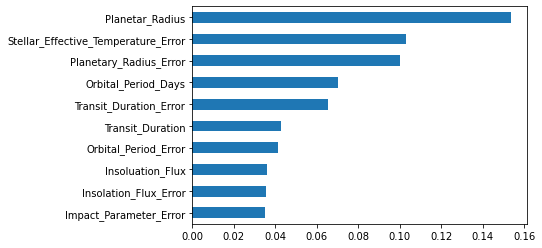

In [439]:
# Test the Feature importances for rnadom forest model
rf_importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
rf_feature_names = X_train.columns
feat_imp_rf = pd.Series(data=rf_importances, index=rf_feature_names).sort_values()

feat_imp_rf.tail(10).plot(kind='barh')
feat_imp_rf.tail(10)

In [440]:
# XGB model after tuning
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42,
                  learning_rate=.06,
                  max_depth=10,
                  subsample=.799999,
                  n_estimators=150,
                  n_jobs=-1)
)

model_xgb.fit(X_train, y_train)

D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:19:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.06,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=150,
                               n_jobs=-1, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.799999, tree_method='exact',
                               validate_parameters=1, verbosity=No

In [441]:
# Created grid search for hypertuning
# param_gridx = {
#     'simpleimputer__strategy': ['mean', 'median'],
#     'xgbclassifier__max_depth': range(5, 40, 5),
#     'xgbclassifier__n_estimators': range(50, 200, 50),
#     'xgbclassifier__learning_rate': np.arange(.02,.1,.02),
#     'xgbclassifier__subsample': np.arange(.7, 1.1, .1)
# }

# model_xgbgs = GridSearchCV(
#     model_xgb,
#     param_grid = param_gridx,
#     n_jobs=-1,
#     cv=5,
#     verbose=1
# )
# model_xgbgs.fit(X_train, y_train)

In [442]:
# The Accuracy of each model
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))
print()
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))
print()
print('Training Accuracy (XGB):', model_xgb.score(X_train, y_train))
print('Validation Accuracy (XGB):', model_xgb.score(X_val, y_val))

Training Accuracy (LOGR): 0.8221502096835684
Validation Accuracy (LOGR): 0.8198970840480274

Training Accuracy (RF): 0.993518871521159
Validation Accuracy (RF): 0.8427672955974843

Training Accuracy (XGB): 0.9990468928707587
Validation Accuracy (XGB): 0.8461978273299028


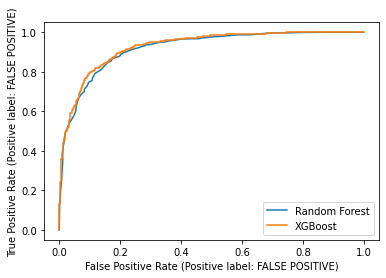

In [443]:
# ROC curve / graph to determine best model
bag = plot_roc_curve(model_rf, X_val, y_val, label='Random Forest')
boost = plot_roc_curve(model_xgb, X_val, y_val, label='XGBoost',  ax=bag.ax_)

In [444]:
# Accuracy ratings for chosen model
print('Training Accuracy (XGB):', model_xgb.score(X_train, y_train))
print('Validation Accuracy (XGB):', model_xgb.score(X_val, y_val))
print('Test Accuracy (XGB):', model_xgb.score(X_test,y_test))

Training Accuracy (XGB): 0.9990468928707587
Validation Accuracy (XGB): 0.8461978273299028
Test Accuracy (XGB): 0.8576329331046312


Stellar_Radius                         0.020721
Stellar_Effective_Temperature          0.020888
Transit_Epoch                          0.020977
Stellar_Surface_Gravity                0.021044
TCE_Planet_Number                      0.021482
Keplar_Band                            0.021493
Transit_Depth                          0.022166
Impact_Parameter                       0.022909
RA                                     0.023295
Transit_Duration                       0.026998
Impact_Parameter_Error                 0.028809
Orbital_Period_Error                   0.028897
Transit_Signal                         0.030031
Insolation_Flux_Error                  0.030974
Equilibrium_Temperature                0.045496
Orbital_Period_Days                    0.051074
Transit_Duration_Error                 0.054506
Stellar_Effective_Temperature_Error    0.082777
Insoluation_Flux                       0.121782
Planetar_Radius                        0.207384
dtype: float32

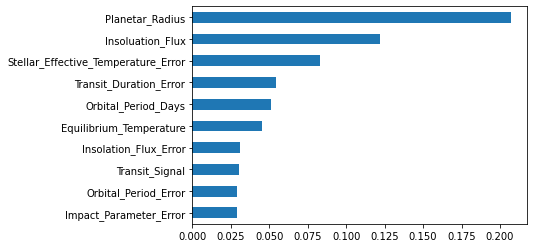

In [445]:
# Feature importances for Chosen model
# These were used when chosing features for app model.
xgb_importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
xgb_feature_names = X_train.columns
feat_imp_xgb = pd.Series(data=xgb_importances, index=xgb_feature_names).sort_values()

feat_imp_xgb.tail(10).plot(kind='barh')
feat_imp_xgb.tail(20)

In [446]:
# Permutation importances for chosen model.
# These were used when chosing features for app model.
perm_imp = permutation_importance(model_xgb,
                                  X_val,
                                  y_val,
                                  n_repeats=5,
                                  n_jobs=-1,
                                  random_state=42)

In [447]:
data = {'imp_mean': perm_imp['importances_mean'],
        'impp_std': perm_imp['importances_std']}

importances = pd.DataFrame(data, index=X_val.columns).sort_values(by='imp_mean')

,imp_mean,impp_std
Stellar_Surface_Gravity_Error,-0.000800,0.001934
Stellar_Surface_Gravity,-0.000686,0.001961
RA,-0.000572,0.001879
Planetary_Radius_Error,-0.000343,0.000929
Transit_Depth,0.000114,0.001994
Impact_Parameter,0.000343,0.003716
Dec,0.000343,0.001177
Stellar_Radius_Error,0.000572,0.001253
Insoluation_Flux,0.001258,0.002463
Transit_Depth_Error,0.001830,0.002618


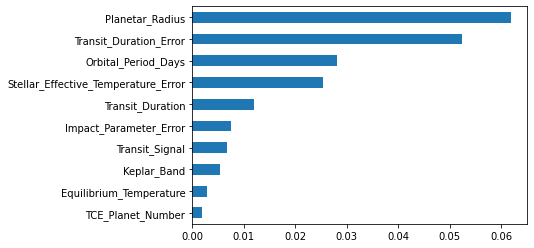

In [448]:
importances['imp_mean'].tail(10).plot(kind='barh')

importances.tail(20)

In [449]:
# Created a seperate function for app
def wrangle2(filepath):
    df = pd.read_csv(filepath, index_col='kepid')
    # https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html
    # Link above provided further explination on what columns represented
    df = df.rename(columns={'kepid': 'KepID',
                            'kepoi_name' : 'Kepler_Name',
                            'koi_disposition' : 'Exoplanet_Archive_Disposition',
                            'koi_pdisposition' : 'Disposition_Using_Kepler_Data',
                            'koi_score' : 'Disposition_Score',
                            'koi_fpflag_nt' : 'Not_Transit-Like_False_Positive_Flag',
                            'koi_fpflag_ss' : 'Stellar_Eclipse_False_Positive_Flag',
                            'koi_fpflag_co' : 'Centroid_Offset_False_Positive_Flag',
                            'koi_fpflag_ec' : 'Ephemeris_Match_Indicates_Contamination_False_Positive_Flag',
                            'koi_period' : 'Orbital_Period_Days',
                            'koi_period_err1' : 'Orbital_Period_Upper',
                            'koi_period_err2' : 'Orbital_Period_Lower',
                            'koi_time0bk' : 'Transit_Epoch',
                            'koi_time0bk_err1' : 'Transit_Epoch_Upper',
                            'koi_time0bk_err2' : 'Transit_Epoch_Lower',
                            'koi_impact' : 'Impact_Parameter',
                            'koi_impact_err1' : 'Impact_Parameter_Upper',
                            'koi_impact_err2' : 'Impact_Parameter_Lower',
                            'koi_duration': 'Transit_Duration',
                            'koi_duration_err1':'Transit_Duration_Upper',
                            'koi_duration_err2':'Transit_Duration_Lower',
                            'koi_depth' : 'Transit_Depth',
                            'koi_depth_err1' : 'Transit_Depth_Upper',
                            'koi_depth_err2' : 'Transit_Depth_Lower',
                            'koi_prad' : 'Planetar_Radius',
                            'koi_prad_err1' : 'Planetary_Radius_Upper',
                            'koi_prad_err2' : 'Planetary_Radius_Lower',
                            'koi_teq' : 'Equilibrium_Temperature',
                            'koi_teq_err1' : 'Equilibrium_Temperature_Upper',
                            'koi_teq_err2' : 'Equilibrium_Temperature_Lower',
                            'koi_insol' : 'Insoluation_Flux',
                            'koi_insol_err1' : 'Insolation_Flux_Upper',
                            'koi_insol_err2' : 'Insolation_Flux_Lower',
                            'koi_model_snr' : 'Transit_Signal',
                            'koi_tce_plnt_num' : 'TCE_Planet_Number',
                            'koi_tce_delivname' : 'TCE_Delive_Name',
                            'koi_steff' : 'Stellar_Effective_Temperature',
                            'koi_steff_err1' : 'Stellar_Effective_Temperature_Upper',
                            'koi_steff_err2' : 'Stellar_Effective_Temperature_Lower',
                            'koi_slogg' : 'Stellar_Surface_Gravity',
                            'koi_slogg_err1' : 'Stellar_Surface_Gravity_Upper',
                            'koi_slogg_err2' : 'Stellar_Surface_Gravity_Lower',
                            'koi_srad' : 'Stellar_Radius',
                            'koi_srad_err1' : 'Stellar_Radius_Upper',
                            'koi_srad_err2' : 'Stellar_Radius_Lower',
                            'ra' : 'RA',
                            'dec' : 'Dec',
                            'koi_kepmag' : 'Keplar_Band',
                
                           })
    #Drop high null Columns
    df = df.drop(columns = ['Equilibrium_Temperature_Upper', 'Equilibrium_Temperature_Lower'])
    
    #Drop for base test
    df = df.drop(columns = ['TCE_Delive_Name', 'Kepler_Name', 'kepler_name','rowid'])
    
    #Drop possible leakage
    df = df.drop(columns = ['Disposition_Score'])
    
    # Drop these for possible leakage. Need to look into further.
    df = df.drop(columns = ['Not_Transit-Like_False_Positive_Flag','Ephemeris_Match_Indicates_Contamination_False_Positive_Flag','Stellar_Eclipse_False_Positive_Flag', 'Centroid_Offset_False_Positive_Flag'])
    
    #Drop Nans for now
    df = df.dropna()
    
    # Combined the Upper and Lower Uncertainty into Error Column
    for col in df.columns:
        if col in df.filter(regex='_Upper', axis=1).columns.to_list():
            df[col.replace('_Upper', '_Error')] = df[col] - df[col.replace('_Upper', '_Lower')]
            df = df.drop(columns= [col,col.replace('_Upper', '_Lower')])
    
    # Chose the best Features from previous analyse and limited the model to those.
    df = df[['Planetar_Radius','Insoluation_Flux','Transit_Signal','Transit_Duration', 'Keplar_Band','Orbital_Period_Days', 'Stellar_Effective_Temperature','Disposition_Using_Kepler_Data']]
    return df

In [450]:
# Set Data for new models with New DataFrame
NASA= wrangle2('D:\\Download\\NASA\\cumulative.csv')
NASA

,Planetar_Radius,Insoluation_Flux,Transit_Signal,Transit_Duration,Keplar_Band,Orbital_Period_Days,Stellar_Effective_Temperature,Disposition_Using_Kepler_Data
kepid,,,,,,,,
10797460,2.26,93.59,35.8,2.95750,15.347,9.488036,5455.0,CANDIDATE
10797460,2.83,9.11,25.8,4.50700,15.347,54.418383,5455.0,CANDIDATE
10811496,14.60,39.30,76.3,1.78220,15.436,19.899140,5853.0,FALSE POSITIVE
10848459,33.46,891.96,505.6,2.40641,15.597,1.736952,5805.0,FALSE POSITIVE
10854555,2.75,926.16,40.9,1.65450,15.509,2.525592,6031.0,CANDIDATE
...,...,...,...,...,...,...,...,...
10031643,1.11,176.40,8.4,4.80600,14.478,8.589871,5638.0,FALSE POSITIVE
10090151,29.35,4500.53,453.3,3.22210,14.082,0.527699,5638.0,FALSE POSITIVE
10128825,0.72,1585.81,10.6,3.11400,14.757,1.739849,6119.0,CANDIDATE


In [451]:
# Set the X and Y for the App Model
target2 = ['Disposition_Using_Kepler_Data']
X2 = NASA.drop(columns=target2)
y2 = NASA[target2]


In [452]:
# Split the Data for Training on App model
X2_remain, X2_test, y2_remain, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42)

X2_train, X2_val, y2_train, y2_val = train_test_split(
    X2_remain, y2_remain, test_size=0.25, random_state=42)

In [453]:
# Tested Logistic Regression App model
model_lr2 = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(max_iter=140)
)

model_lr2.fit(X2_train, y2_train)

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=140))])

In [454]:
# Tested Random Forest App model
model_rf2 = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(max_depth=35,
                          max_features=.7,
                          max_samples=.7,
                          n_estimators=100)

)

model_rf2.fit(X2_train, y2_train)

D:\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=35, max_features=0.7,
                                        max_samples=0.7))])

In [455]:
# Used gride seearch for Random forest hyper tuning

# param_grid = {
#     'simpleimputer__strategy': ['mean', 'median'],
#     'randomforestclassifier__max_depth': range(5, 40, 5),
#     'randomforestclassifier__n_estimators': range(25, 125, 25),
#     'randomforestclassifier__max_samples': np.arange(.1,1,.2),
#     'randomforestclassifier__max_features': np.arange(.1,1,.2)
# }

# model_rfgs2 = GridSearchCV(
#     model_rf2,
#     param_grid = param_grid,
#     n_jobs=-1,
#     cv=5,
#     verbose=1
# )
# model_rfgs2.fit(X_train, y_train)

In [456]:
model_xgb2 = make_pipeline(
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42,
                  learning_rate=.08,
                  n_estimators=50,
                  subsample=.7,
                  n_jobs=-1)
)

model_xgb2.fit(X2_train, y2_train)

[02:19:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.08,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=-1, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.7, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [457]:
# Used gride seearch for XGBoost hyper tuning

# param_gridx = {
#     'simpleimputer__strategy': ['mean', 'median'],
#     'xgbclassifier__max_depth': range(35, 55, 5),
#     'xgbclassifier__n_estimators': range(25, 100, 25),
#     'xgbclassifier__learning_rate': np.arange(.06,.1,.01),
#     'xgbclassifier__subsample': np.arange(.6, .8, .1)
# }

# model_xgbgs2 = GridSearchCV(
#     model_xgb,
#     param_grid = param_gridx,
#     n_jobs=-1,
#     cv=5,
#     verbose=1
# )
# model_xgbgs2.fit(X2_train, y2_train)

In [458]:
print('Training Accuracy (LOGR):', model_lr2.score(X2_train, y2_train))
print('Validation Accuracy (LOGR):', model_lr2.score(X2_val, y2_val))
print()
print('Training Accuracy (RF):', model_rf2.score(X2_train, y2_train))
print('Validation Accuracy (RF):', model_rf2.score(X2_val, y2_val))
print()
print('Training Accuracy (XGB):', model_xgb2.score(X2_train, y2_train))
print('Validation Accuracy (XGB):', model_xgb2.score(X2_val, y2_val))

Training Accuracy (LOGR): 0.6725123903926802
Validation Accuracy (LOGR): 0.6558033161806747

Training Accuracy (RF): 0.990659550133435
Validation Accuracy (RF): 0.8301886792452831

Training Accuracy (XGB): 0.8827678231033168
Validation Accuracy (XGB): 0.8364779874213837


In [459]:
import joblib
import sklearn
import xgboost
import category_encoders
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'xgboost=={xgboost.__version__}')
print(f'category_encoders=={category_encoders.__version__}')

joblib==1.0.1
scikit-learn==0.24.1
xgboost==1.4.2
category_encoders==2.2.2


In [460]:
from joblib import dump
dump(model_xgbgs2, 'model_xgbapp.joblib', compress=True)

['model_xgbapp.joblib']

In [461]:
NASA['Planetar_Radius'].describe()

count      8744.000000
mean        103.932190
std        3151.780687
min           0.140000
25%           1.400000
50%           2.400000
75%          14.872500
max      200346.000000
Name: Planetar_Radius, dtype: float64

In [462]:
NASA.profile_report(minimal = True)

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]